# ResNet

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = (480, 320) # change -1
dim_div_by = 64

In [2]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'
 
INPUT = 'meshgrid'
input_depth = 3
input_chanel = 3
LR = 0.01 
num_iter = 15001
param_noise = False
show_every = 1000
save_every = 50000
figsize = 1
reg_noise_std = 0.03    

In [3]:
def make_model_skip(input_shape = 3, input_depth = 3, pad = 'reflection', depth=6):
    n = skip(input_depth, input_shape, 
               num_channels_down = [128] * depth, #[16, 32, 64, 128, 128, 128][:depth],
               num_channels_up   = [128] * depth, #[16, 32, 64, 128, 128, 128][:depth],
               num_channels_skip = [128] * depth, #[0,0,0,0,0,0][:depth], 
               upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    return n


def make_model_UNet(input_shape = 3, input_depth = 3):
    n = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=8, more_layers=1, 
                   concat_x=False, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True).type(dtype)
        
    LR = 0.001
    param_noise = False
    return n

def make_model_ResNet(input_shape = 3, input_depth = 3):
    n = ResNet(input_depth, input_shape, 8, 32, need_sigmoid=True, act_fun='LeakyReLU').type(dtype)
        
    LR = 0.001
    param_noise = False
    return n


def test_image(img_path = 'data/inpainting/vase.png', image_size = imsize, img_mask_np1 = None): 
    img_pil1, img_np1 = get_image(img_path, image_size)
    if img_mask_np1 is None:
        img_mask_np1 = make_random_mask((1,image_size[1],image_size[0]))
    test = np_to_torch(img_np1 * img_mask_np1).type(dtype)
    out1 = net(test)
    out_np1 = torch_to_np(out1)
    plot_image_grid([np.clip(out_np1, 0, 1), img_mask_np1, img_np1 * img_mask_np1], factor=20, nrow=3);
    
    
def test_image2(img_path = 'data/inpainting/vase.png', image_size = imsize, img_mask_np1 = None): 
    img_pil1, img_np1 = get_image(img_path, image_size)
    if img_mask_np1 is None:
        img_mask_np1 = make_random_mask((1,image_size[1],image_size[0]))
    test = np_to_torch(img_np1 * img_mask_np1).type(dtype)
    out1 = net(test)
    out_np1 = torch_to_np(out1)
    plot_image_grid([np.clip(out_np1, 0, 1), img_np1], factor=20, nrow=2);
    
    
def test_image_wm(img_path = 'data/inpainting/vase.png', mask_path = 'data/inpainting/kate_mask.png', image_size = imsize, img_mask_np1 = None): 
    img_pil1, img_np1 = get_image(img_path, image_size)
    if img_mask_np1 is None:
        _,img_mask_np1 = get_image(mask_path, imsize) 
        if(img_mask_np1.shape[0] == 4):
            img_mask_np1 = (img_mask_np1[0][:][:] +  img_mask_np1[1][:][:] +  img_mask_np1[2][:][:] +  img_mask_np1[3][:][:]) / 4
            #img_mask_ = img_mask_[0:1]
            #img_mask_[img_mask_==0]=1
            pass
    test = np_to_torch(img_np1 * img_mask_np1).type(dtype)
    out1 = net(test)
    out_np1 = torch_to_np(out1)
    plot_image_grid([np.clip(out_np1, 0, 1), img_mask_np1 * img_np1, img_np1], factor=20, nrow=3);    
        
def make_random_mask(shape, dtype = np.float32, w= None, h = None):
    m = np.ones(shape, dtype=dtype)
    if w is None:
        w = int(shape[2] * .5)
    if h is None:
        h = int(shape[1] * .2)
    w = int(w /2 + np.random.randint(w/2, size=1)[0])
    h = int(h /2 + np.random.randint(h/2, size=1)[0])
    x = np.random.randint(shape[2] - w, size=1)[0]
    y = np.random.randint(shape[1] - h, size=1)[0]
    #print(w,h, x, y)
    #m[0][x:x+w][y:y+h] = 0
    m[0][y:y+h,x:x+w] =0
    return m  

def save_model(model, fpath = 'tmp/model_%d_%d.net', i = 0):
    ts = time.time()
    fpath = fpath % (ts, i)
    torch.save(model, fpath)
    


def make_mask(shape, dtype = np.float32,x=0,y=0, w= 180, h = 50):
    m = np.ones(shape, dtype=dtype) 
    m[0][y:y+h,x:x+w] =0
    return m    

In [4]:
# init net 

mse = torch.nn.MSELoss().type(dtype)
net = make_model_ResNet()

# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)



Number of params: 159555


In [5]:
from os import listdir
from os.path import isfile, join

#  'data/train2014/'# 
data_path = '/home/usergpu/dev/data/'# 'data/train2014/'#'/home/user/dev/generative_inpainting/data/training/'
onlyfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
print(len(onlyfiles))
train_data = [data_path + f for f in onlyfiles]

3173


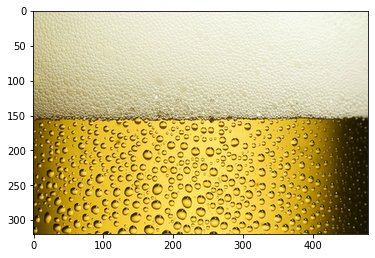

In [6]:
_, img_np_ = get_image(train_data[1], imsize)
plot_image_grid([img_np_], factor=5, nrow=1);

In [7]:
arr_total_loss = []

Starting optimization with ADAM


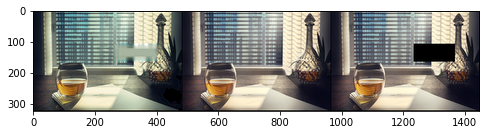

Given groups=1, weight of size 32 3 3 3, expected input[1, 4, 322, 482] to have 3 channels, but got 4 channels instead


In [ ]:
i = 0

def closure():
    
    global i  
    
    try:
        index = np.random.randint(len(train_data), size=1)[0]
        image = train_data[index]
        _,img_np_ = get_image(image, imsize)
    except Exception as e:
        print(e)
        return 0.01
    img_mask_ = make_random_mask((1, imsize[1], imsize[0])) #train_data[index][1]
    #index_mask = np.random.randint(len(masks_list), size=1)[0]
    #img_mask_ = masks_list[index_mask]

    X = np_to_torch(img_np_ * img_mask_).type(dtype)
    X_true = np_to_torch(img_np_).type(dtype)
    X_mask_var = np_to_torch(img_mask_).type(dtype)
    
    if reg_noise_std > 0:
        #X = X + (X.normal_() * reg_noise_std) 
        pass
        
    try:    
        out = net(X)
    except Exception as e:
        print(e)  
        return 0.01
       

    total_loss = mse(out, X_true)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % 5000 == 0:
        out_np = torch_to_np(out) 
        plot_image_grid([np.clip(out_np, 0, 1), img_np_, img_np_ * img_mask_], factor=5, nrow=3)
        arr_total_loss.append(total_loss)
        
    if i % 50000 == 0:
        ts = time.time()
        fpath = 'tmp/file_%d_%d.net' % (ts, i)
        torch.save(net, fpath)
    #if i % 5000 == 0:
        #train_data =  make_data_train()
        #print('update data')
        
    i += 1

    return total_loss 



num_iter = len(train_data) * 3000
_, img_np_ = get_image(train_data[0], imsize)
X = np_to_torch(img_np_).type(dtype)
p = get_params(OPT_OVER, net, X)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
save_model(net, 'tmp/model_test_resnet_%d_%d.net')

In [ ]:
plt.plot(arr_total_loss)